# Lesson 1 - Identify teacup varieties

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results.

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai import *
from fastai.vision import *

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

Get four types of tea cup images from google: Royal Albert, Paragon, Aynsley, and Shelley. 

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels.

In [5]:
folder = 'royal_albert'
file = 'royal_albert_urls.txt'

In [8]:
folder = 'paragon'
file = 'paragon_urls.txt'

In [12]:
folder = 'aynsley'
file = 'aynsley_urls.txt'

In [15]:
folder = 'shelley'
file = 'shelley_urls.txt'

In [16]:
path = Path('../data/teacups')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [4]:
path = Path('../data/teacups')

Finally, upload your urls file. Now you will need to download you images from their respective urls.

In [17]:
download_images(path/file, dest, max_pics=500)

Error https://i.etsystatic.com/8155076/r/il/d3c708/1526433546/il_fullxfull.1526433546_cxk6.jpg 'content-length'
Error https://pixl.varagesale.com/http://s3.amazonaws.com/hopshop-image-store-production/141733775/7e97576958470590c2cb672e55cc6ab7.jpg?_ver=large_uploader_thumbnail&w=640&h=640&fit=crop&s=782c71cb411c089b4c2f09b9215972be 'content-length'
Error http://thumb1.zeppy.io/d/l400/pict/283215766855/orphan-shelley-tea-cup-violets-pattern 'content-length'
Error https://emptyhead.info/wp-content/uploads/2018/07/white-tea-cups-unique-shelley-tea-cup-and-saucer-white-dainty-of-white-tea-cups.jpg 'content-length'
Error https://ebth-com-production.imgix.net/2018/03/13/08/43/11/38edbce8-19d7-4eaf-803a-5580a7e5cc50/MAL_6457.JPG?ixlib=rb-1.1.0&w=880&h=880&fit=crop&crop=&auto=format 'content-length'
Error https://i.etsystatic.com/8155076/r/il/1c5c0b/1600439194/il_fullxfull.1600439194_rfmj.jpg 'content-length'
Error http://thumb1.zeppy.io/d/l400/pict/153171089192/shelley-tea-cup-saucer-turquois

Let's take a look at some of our pictures then.

In [18]:
classes = ['royal_albert','paragon','aynsley','shelley']

In [19]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

royal_albert


cannot identify image file '/home/jupyter/coursework/data/teacups/royal_albert/00000123.jpg'
cannot identify image file '/home/jupyter/coursework/data/teacups/royal_albert/00000166.jpg'
cannot identify image file '/home/jupyter/coursework/data/teacups/royal_albert/00000156.jpg'


/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2655: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


cannot identify image file '/home/jupyter/coursework/data/teacups/royal_albert/00000143.jpg'


/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2655: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


cannot identify image file '/home/jupyter/coursework/data/teacups/royal_albert/00000358.jpg'
paragon


cannot identify image file '/home/jupyter/coursework/data/teacups/paragon/00000099.jpg'
aynsley


cannot identify image file '/home/jupyter/coursework/data/teacups/aynsley/00000031.jpg'
cannot identify image file '/home/jupyter/coursework/data/teacups/aynsley/00000272.jpg'
cannot identify image file '/home/jupyter/coursework/data/teacups/aynsley/00000016.jpg'
shelley


cannot identify image file '/home/jupyter/coursework/data/teacups/shelley/00000411.jpg'
cannot identify image file '/home/jupyter/coursework/data/teacups/shelley/00000045.jpg'
cannot identify image file '/home/jupyter/coursework/data/teacups/shelley/00000403.jpg'
cannot identify image file '/home/jupyter/coursework/data/teacups/shelley/00000041.jpg'
cannot identify image file '/home/jupyter/coursework/data/teacups/shelley/00000289.jpg'


In [5]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, bs=bs)

In [6]:
data.normalize(imagenet_stats)

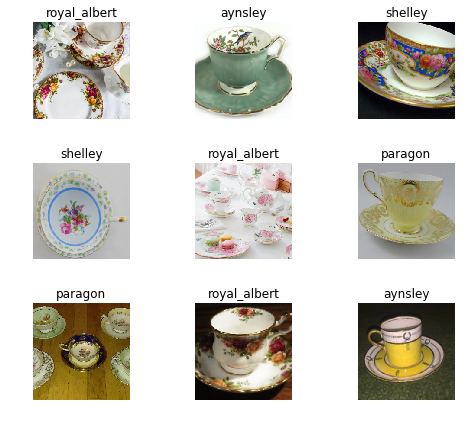

In [7]:
data.show_batch(rows=3, figsize=(7,6))

In [8]:
print(data.classes)
len(data.classes),data.c # need to get rid of 'models' class - where does this come from?

['aynsley', 'models', 'paragon', 'royal_albert', 'shelley']


(5, 5)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 4 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [9]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [10]:
learn.fit_one_cycle(4)

Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.748219    1.127969    0.426966    (00:15)
2      1.370363    1.030547    0.373596    (00:13)
3      1.155994    0.997758    0.401685    (00:14)
4      1.015035    1.024797    0.435393    (00:13)



In [12]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [13]:
valid = learn.get_preds()

In [16]:
valid[0] #predictions on validation set -> 356 x 5 -> need to turn this into probability and somehow get rid of models

tensor([[0.9357, 0.0025, 0.0599, 0.0003, 0.0016],
        [0.0683, 0.0186, 0.0793, 0.0911, 0.7426],
        [0.8994, 0.0041, 0.0246, 0.0112, 0.0609],
        ...,
        [0.0104, 0.0050, 0.0101, 0.0040, 0.9705],
        [0.1512, 0.0078, 0.0214, 0.0195, 0.8001],
        [0.0102, 0.0042, 0.0084, 0.0399, 0.9373]])

In [17]:
valid[1] #targets / labels -> 356

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

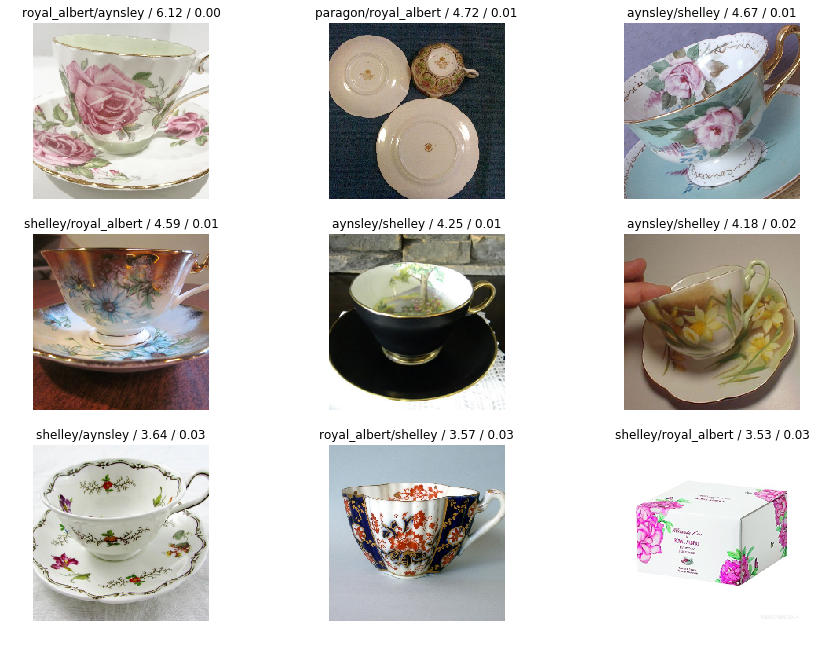

In [19]:
interp.plot_top_losses(9, figsize=(15,11))

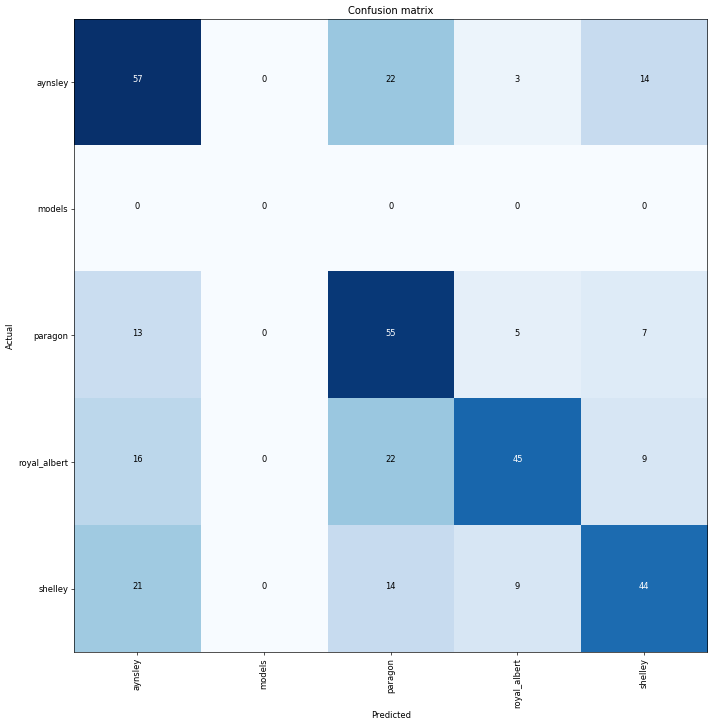

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[('aynsley', 'paragon', 22),
 ('royal_albert', 'paragon', 22),
 ('shelley', 'aynsley', 21),
 ('royal_albert', 'aynsley', 16),
 ('aynsley', 'shelley', 14),
 ('shelley', 'paragon', 14),
 ('paragon', 'aynsley', 13),
 ('royal_albert', 'shelley', 9),
 ('shelley', 'royal_albert', 9),
 ('paragon', 'shelley', 7),
 ('paragon', 'royal_albert', 5),
 ('aynsley', 'royal_albert', 3)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(1)

Total time: 00:16
epoch  train_loss  valid_loss  error_rate
1      1.332835    2.838795    0.542135    (00:16)



In [24]:
learn.load('stage-1')

In [25]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


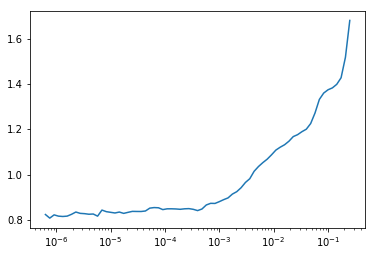

In [26]:
learn.recorder.plot()

In [27]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

Total time: 01:03
epoch  train_loss  valid_loss  error_rate
1      0.989874    0.980465    0.384831    (00:15)
2      0.876740    0.965767    0.401685    (00:15)
3      0.824152    0.962634    0.393258    (00:15)
4      0.803719    0.947368    0.373596    (00:16)



## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network might eat up our GPU memory.

In [37]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, bs=10)
data.normalize(imagenet_stats)

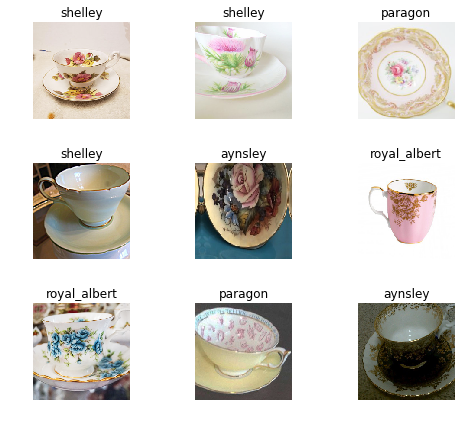

In [38]:
data.show_batch(rows=3, figsize=(7,6))

In [39]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [40]:
learn.fit_one_cycle(8, max_lr=slice(1e-3))

Total time: 02:44
epoch  train_loss  valid_loss  error_rate
1      1.518019    1.243424    0.429379    (00:23)
2      1.207052    1.184802    0.426554    (00:20)
3      1.147182    1.072883    0.406780    (00:19)
4      0.951218    1.009127    0.381356    (00:20)
5      0.817811    0.937030    0.353107    (00:20)
6      0.717243    0.928031    0.333333    (00:19)
7      0.684602    0.932954    0.341808    (00:20)
8      0.615761    0.918676    0.364407    (00:20)



In [56]:
learn.save('stage-1-50')

In [42]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 01:23
epoch  train_loss  valid_loss  error_rate
1      0.593334    0.917190    0.330508    (00:28)
2      0.582269    0.893559    0.327684    (00:27)
3      0.533286    0.864340    0.316384    (00:27)



In [48]:
interp = ClassificationInterpretation.from_learner(learn)

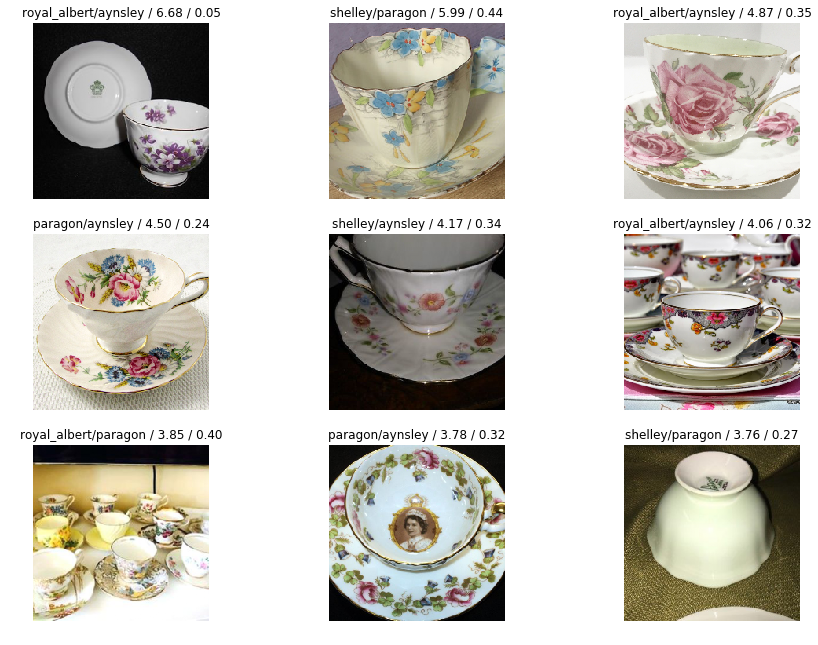

In [49]:
interp.plot_top_losses(9, figsize=(15,11))

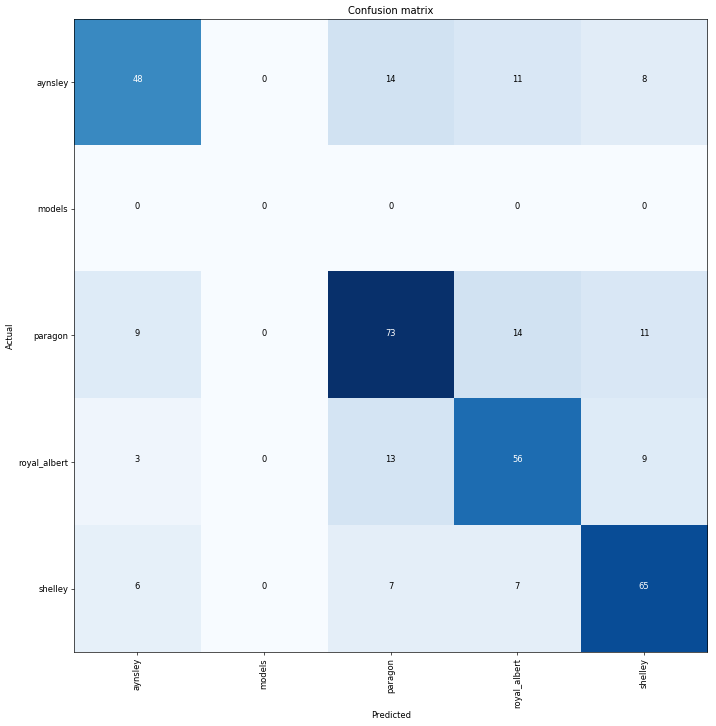

In [57]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [51]:
interp.most_confused(min_val=2)

[('aynsley', 'paragon', 14),
 ('paragon', 'royal_albert', 14),
 ('royal_albert', 'paragon', 13),
 ('aynsley', 'royal_albert', 11),
 ('paragon', 'shelley', 11),
 ('paragon', 'aynsley', 9),
 ('royal_albert', 'shelley', 9),
 ('aynsley', 'shelley', 8),
 ('shelley', 'paragon', 7),
 ('shelley', 'royal_albert', 7),
 ('shelley', 'aynsley', 6),
 ('royal_albert', 'aynsley', 3)]